In [3]:
import pandas as pd
import numpy as np
import sklearn

import matplotlib
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
%matplotlib inline

In [4]:
import torch

from torch.optim import lr_scheduler
import torch.optim as optim
from torch.autograd import Variable

from trainer import fit,train_epoch
import numpy as np
cuda = torch.cuda.is_available()

In [6]:
from datasets import TripletSampling, BatchPairSampling
from networks import EmbeddingNet, TripletNet, SiameseNet
from losses import TripletLoss, HardHardNegativesBatchLoss, HardEasyNegativesBatchLoss, SCTLossCosine

In [7]:
def extract_embeddings(dataset, labels, model):
    with torch.no_grad():
        model.eval()
        embeddings = []

        for data in dataset:

            embeddings.append( 
                np.array( 
                    model.get_embedding(data).detach().numpy() ) )

    return np.array(embeddings), labels

def plot_embeddings(embeddings, targets, xlim=None, ylim=None):
    plt.figure(figsize=(10,10))
    targets = np.array(targets)
    colors = ['r', 'b']
    shapes = ['*', '^']
    for cls in set(targets):
        mask = targets == cls
        cls_emb = embeddings[mask]
        plt.scatter(cls_emb[:,0], cls_emb[:,1], alpha=0.5, marker = shapes[cls],c = colors[cls])

    plt.legend(set(targets))
    
def dissim_matrix(data, name):
    """helper for mds visualization"""
    from scipy.spatial import distance
    return distance.cdist(data, data, metric= name)

def smaples_for_plotting(percentage, labels, data):
    """ reduce # of data, for plotting"""
    percentage = 0.5
    labels = np.array(labels)
    label_to_indices = {label: np.where(labels == label)[0]
                             for label in labels}


    true_num = int( len(label_to_indices[1]) * percentage )
    false_num = int( len(label_to_indices[0]) * percentage )

    positive_index = np.random.choice( label_to_indices[1], true_num)
    negative_index= np.random.choice(label_to_indices[0], false_num)

    index = np.concatenate( [positive_index, negative_index], axis = 0)

    return data[index], labels[index]


tsne = TSNE(n_components=2, perplexity = 5, learning_rate='auto',init='random')
mds = sklearn.manifold.MDS(n_components=2,metric= True, 
                                  n_init=4, 
                                  max_iter=100,
                                  verbose=0, eps=0.001, n_jobs=-1, random_state= 10, dissimilarity='precomputed')

## Friedman

In [123]:
friedman = pd.read_csv('./data/Friedman_data.csv')
drop_columns = ['y']
friedman = friedman.drop(drop_columns, axis = 1)

In [124]:
friedman_shuffled = friedman.sample(frac=1).reset_index(drop=True)
from sklearn.mixture import GaussianMixture

# use Gs to do clustering
labels = GaussianMixture(n_components=2, random_state=0).fit_predict(friedman_shuffled)

In [125]:
train_X_fried, test_X_fried,train_label_fried, test_label_fried = train_test_split(
    friedman_shuffled, labels, test_size=0.33, random_state=42)

train_X_fried_tensor = torch.tensor(train_X_fried.values )
test_X_fried_tensor = torch.tensor(test_X_fried.values )

In [126]:
distance = None
margin = 1

lam = 1
# method = 'sct'
method = 'hn' #shn now is the best
loss_fn = SCTLossCosine( method = method, lam = lam)

lr = 1e-5

hidden_size = 20
embedding_size = 5
input_size = train_X_fried_tensor.shape[1]

net = EmbeddingNet(input_size, hidden_size, embedding_size)
siamese_net = SiameseNet(  embedding_net = net )



model = siamese_net
model = model.float() 
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 80

datasampler = BatchPairSampling( dataset = train_X_fried_tensor , labels= train_label_fried)
batch_size = 100
train_loader = torch.utils.data.DataLoader(datasampler, batch_size=batch_size, shuffle=True)

interval = 20

In [127]:
%%time
fit(train_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, interval)

Train: [0/670 (0%)]	Loss: 0.693651
Epoch: 1/80. Train set: Average loss: 0.3964
Train: [0/670 (0%)]	Loss: 0.693681
Epoch: 2/80. Train set: Average loss: 0.3964
Train: [0/670 (0%)]	Loss: 0.693656
Epoch: 3/80. Train set: Average loss: 0.5946
Train: [0/670 (0%)]	Loss: 0.693628
Epoch: 4/80. Train set: Average loss: 0.4955
Train: [0/670 (0%)]	Loss: 0.000000
Epoch: 5/80. Train set: Average loss: 0.3964
Train: [0/670 (0%)]	Loss: 0.000000
Epoch: 6/80. Train set: Average loss: 0.2973
Train: [0/670 (0%)]	Loss: 0.693661
Epoch: 7/80. Train set: Average loss: 0.0991
Train: [0/670 (0%)]	Loss: 0.000000
Epoch: 8/80. Train set: Average loss: 0.2973
Train: [0/670 (0%)]	Loss: 0.000000
Epoch: 9/80. Train set: Average loss: 0.1982
Train: [0/670 (0%)]	Loss: 0.693658
Epoch: 10/80. Train set: Average loss: 0.3964
Train: [0/670 (0%)]	Loss: 0.000000
Epoch: 11/80. Train set: Average loss: 0.1982
Train: [0/670 (0%)]	Loss: 0.000000
Epoch: 12/80. Train set: Average loss: 0.1982
Train: [0/670 (0%)]	Loss: 0.693634
Ep

#### Visualize train

In [128]:
train_embs,train_labels = extract_embeddings(train_X_fried_tensor , train_label_fried, model)

In [129]:
name = 'cosine'
train_dis = dissim_matrix(train_embs, name)

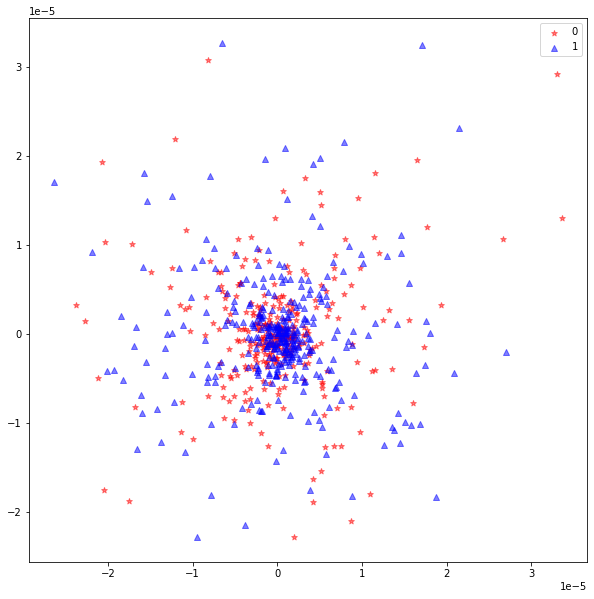

In [130]:
embedded_2_train = mds.fit_transform(train_dis)
plot_embeddings(embedded_2_train, train_labels)

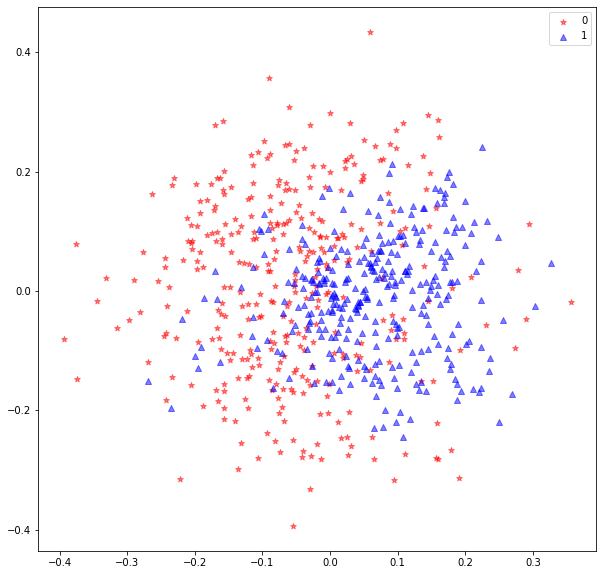

In [18]:
name = 'cosine'
train_orig_dis = dissim_matrix(train_X_fried_tensor, name)

embedded_2_train_orig = mds.fit_transform(train_orig_dis)
plot_embeddings(embedded_2_train_orig, train_labels)

#### visualize test

In [131]:
test_embs,test_labels = extract_embeddings(test_X_fried_tensor , test_label_fried, model)

In [132]:
name = 'cosine'
test_dis = dissim_matrix(test_embs, name)

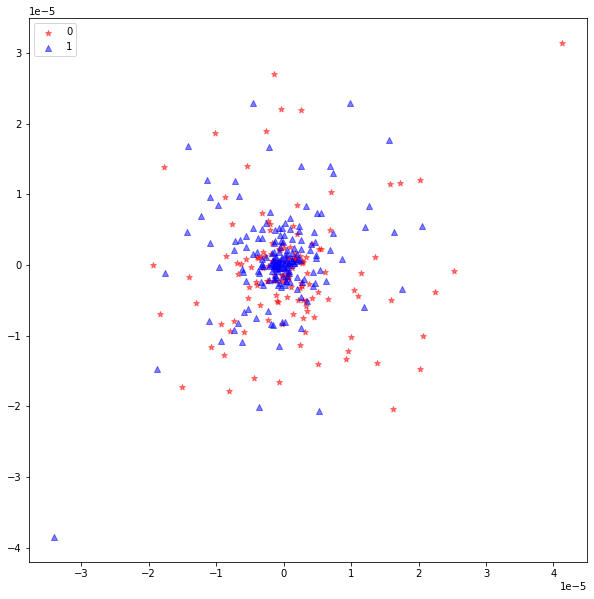

In [133]:
embedded_2_test = mds.fit_transform(test_dis)
plot_embeddings(embedded_2_test, test_labels)

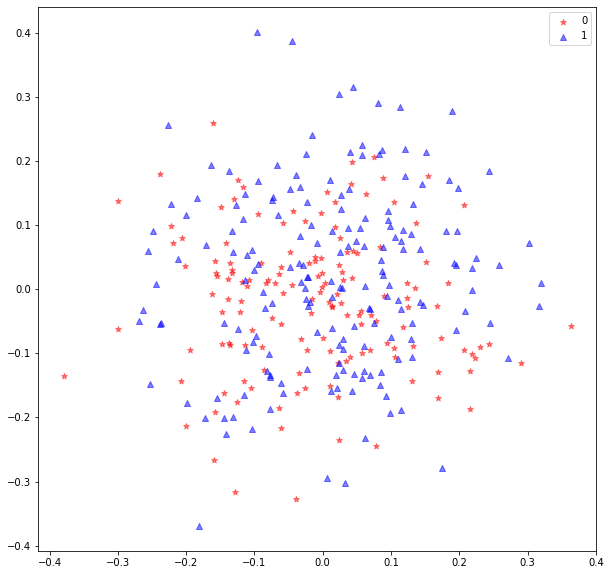

In [134]:
name = 'cosine'
test_orig_dis = dissim_matrix(test_X_fried_tensor, name)

embedded_2_test_orig = mds.fit_transform(test_orig_dis)
plot_embeddings(embedded_2_test_orig, test_labels)

## Diffusion - chemical grouping

In [82]:
diffusion = pd.read_csv('./data/Diffusion_data.csv')
diffusion_shuffled = diffusion.sample(frac=1).reset_index(drop=True)
labels = []
for name in diffusion_shuffled ['group']:
    if name == 'transition_metal':
        labels.append(1)
    else:
        labels.append(0)

drop_columns = ['E_regression', 'E_regression_shift', 'group',
               'Material compositions 2', 'Material compositions 1']
diffusion_shuffled  = diffusion_shuffled .drop(drop_columns, axis = 1)

In [83]:
train_X_diffu, test_X_diffu,train_label_diffu, test_label_diffu = train_test_split(
    diffusion_shuffled, labels, test_size=0.33, random_state=42)

train_X_diffu_tensor = torch.tensor(train_X_diffu.values )
test_X_diffu_tensor = torch.tensor(test_X_diffu.values )

In [86]:
distance = None
margin = 2

lam = 1
# method = 'sct'
method = 'hn' #shn now is the best
loss_fn = SCTLossCosine( method = method, lam = lam)
lr = 1e-3

hidden_size = 100
embedding_size = 20
input_size = train_X_diffu_tensor.shape[1]
net = EmbeddingNet(input_size, hidden_size, embedding_size)
siamese_net = SiameseNet(  embedding_net = net )



model = siamese_net
model = model.float() 
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20

datasampler = BatchPairSampling( dataset = train_X_diffu_tensor, labels= train_label_diffu)
batch_size = 100
train_loader = torch.utils.data.DataLoader(datasampler, batch_size=batch_size, shuffle=True)

interval = 10

In [87]:
%%time
fit(train_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, interval)

Train: [0/273 (0%)]	Loss: 0.695516
Epoch: 1/20. Train set: Average loss: 0.6944
Train: [0/273 (0%)]	Loss: 0.693737
Epoch: 2/20. Train set: Average loss: 0.6938
Train: [0/273 (0%)]	Loss: 0.694035
Epoch: 3/20. Train set: Average loss: 0.6941
Train: [0/273 (0%)]	Loss: 0.694322
Epoch: 4/20. Train set: Average loss: 0.6940
Train: [0/273 (0%)]	Loss: 0.693879
Epoch: 5/20. Train set: Average loss: 0.6938
Train: [0/273 (0%)]	Loss: 0.000000
Epoch: 6/20. Train set: Average loss: 0.0000
Train: [0/273 (0%)]	Loss: 0.000000
Epoch: 7/20. Train set: Average loss: 0.0000
Train: [0/273 (0%)]	Loss: 0.000000
Epoch: 8/20. Train set: Average loss: 0.0000
Train: [0/273 (0%)]	Loss: 0.000000
Epoch: 9/20. Train set: Average loss: 0.0000
Train: [0/273 (0%)]	Loss: 0.000000
Epoch: 10/20. Train set: Average loss: 0.0000
Train: [0/273 (0%)]	Loss: 0.000000
Epoch: 11/20. Train set: Average loss: 0.0000
Train: [0/273 (0%)]	Loss: 0.000000
Epoch: 12/20. Train set: Average loss: 0.0000
Train: [0/273 (0%)]	Loss: 0.000000
Ep

#### Visualize train

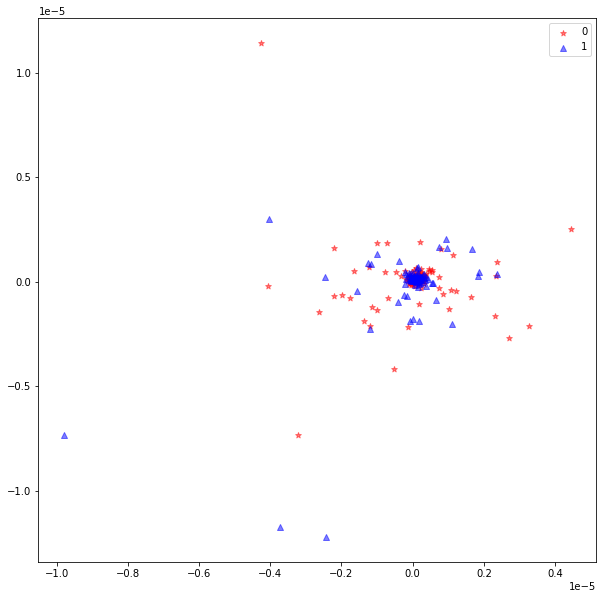

In [88]:
train_embs,train_labels = extract_embeddings(train_X_diffu_tensor , train_label_diffu, model)
name = 'cosine'
train_dis = dissim_matrix(train_embs, name)
embedded_2_train = mds.fit_transform(train_dis)
plot_embeddings(embedded_2_train, train_labels)

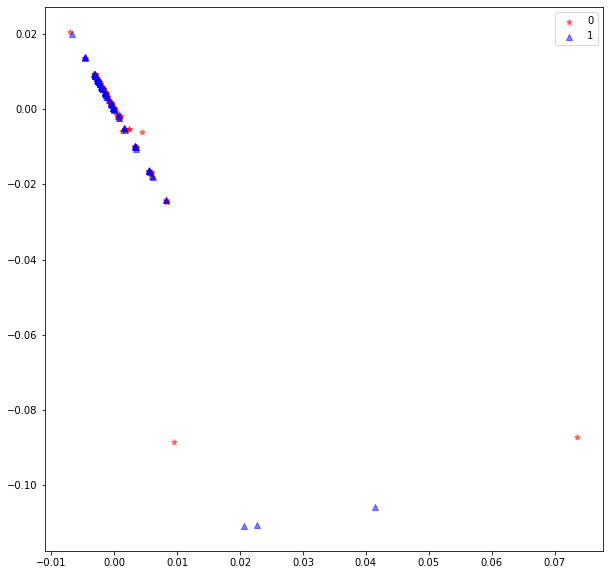

In [89]:
name = 'cosine'
train_orig_dis = dissim_matrix(train_X_diffu_tensor, name)

embedded_2_train_orig = mds.fit_transform(train_orig_dis)
plot_embeddings(embedded_2_train_orig, train_labels)

#### Visualize test

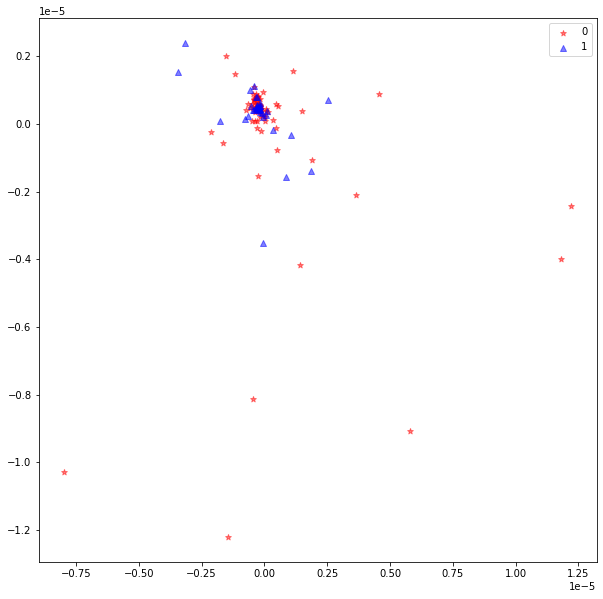

In [90]:
test_embs,test_labels = extract_embeddings(test_X_diffu_tensor , test_label_diffu, model)
name = 'cosine'
test_dis = dissim_matrix(test_embs, name)
embedded_2_test = mds.fit_transform(test_dis)
plot_embeddings(embedded_2_test, test_labels)

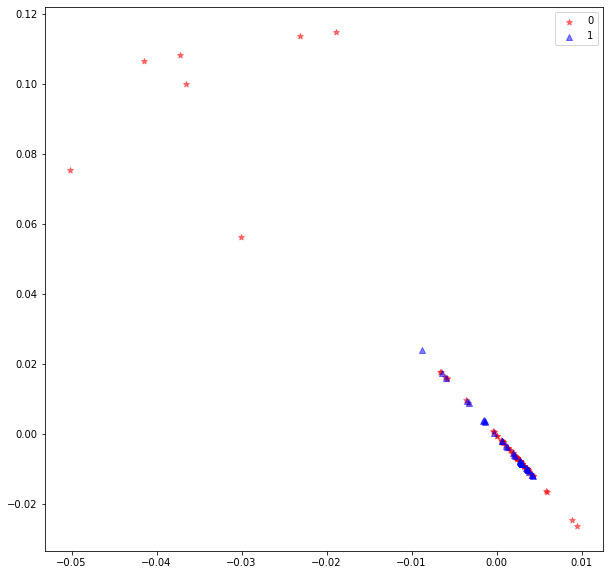

In [91]:
name = 'cosine'
test_orig_dis = dissim_matrix(test_X_diffu_tensor, name)

embedded_2_test_orig = mds.fit_transform(test_orig_dis)
plot_embeddings(embedded_2_test_orig, test_labels)

### Supercond - chemical grouping

In [177]:

supercond = pd.read_excel('./data/Supercon_data_features_selected.xlsx')
supercond_shuffled = supercond.sample(frac=1).reset_index(drop=True)

labels = []
for name in supercond['group']:
    if name == 'cuprates':
        labels.append(1)
    else:
        labels.append(0)
supercond['group'] = labels


drop_columns = [
                 'name',
                 'group',
                 'Tc', 'ln(Tc)'
                 ]
supercond_shuffled  = supercond_shuffled .drop(drop_columns, axis = 1)

In [178]:
train_X_supercond, test_X_supercond,train_label_supercond, test_label_supercond = train_test_split(
    supercond_shuffled, labels, test_size=0.33, random_state=42)

train_X_supercond_tensor = torch.tensor(train_X_supercond.values )
test_X_supercond_tensor = torch.tensor(test_X_supercond.values )

In [189]:
distance = None
margin = 2

lam = 1
# method = 'sct'
method = 'hn' #shn now is the best
loss_fn = SCTLossCosine( method = method, lam = lam)
lr = 1e-4

hidden_size = 100
embedding_size = 20
input_size = train_X_supercond_tensor.shape[1]
net = EmbeddingNet(input_size, hidden_size, embedding_size)
siamese_net = SiameseNet(  embedding_net = net )



model = siamese_net
model = model.float() 
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 50

datasampler = BatchPairSampling( dataset = train_X_supercond_tensor, labels= train_label_supercond)
batch_size = 200
train_loader = torch.utils.data.DataLoader(datasampler, batch_size=batch_size, shuffle=True)

interval = 200

In [190]:
%%time
fit(train_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, interval)

Train: [0/4188 (0%)]	Loss: 0.693997
Epoch: 1/50. Train set: Average loss: 0.6940
Train: [0/4188 (0%)]	Loss: 0.693737
Epoch: 2/50. Train set: Average loss: 0.6937
Train: [0/4188 (0%)]	Loss: 0.693755
Epoch: 3/50. Train set: Average loss: 0.6938
Train: [0/4188 (0%)]	Loss: 0.693692
Epoch: 4/50. Train set: Average loss: 0.6937
Train: [0/4188 (0%)]	Loss: 0.693702
Epoch: 5/50. Train set: Average loss: 0.6938
Train: [0/4188 (0%)]	Loss: 0.693630
Epoch: 6/50. Train set: Average loss: 0.3633
Train: [0/4188 (0%)]	Loss: 0.000000
Epoch: 7/50. Train set: Average loss: 0.0330
Train: [0/4188 (0%)]	Loss: 0.693633
Epoch: 8/50. Train set: Average loss: 0.0991
Train: [0/4188 (0%)]	Loss: 0.000000
Epoch: 9/50. Train set: Average loss: 0.0991
Train: [0/4188 (0%)]	Loss: 0.000000
Epoch: 10/50. Train set: Average loss: 0.0000
Train: [0/4188 (0%)]	Loss: 0.000000
Epoch: 11/50. Train set: Average loss: 0.0000
Train: [0/4188 (0%)]	Loss: 0.000000
Epoch: 12/50. Train set: Average loss: 0.0000
Train: [0/4188 (0%)]	Loss

#### Visualize train

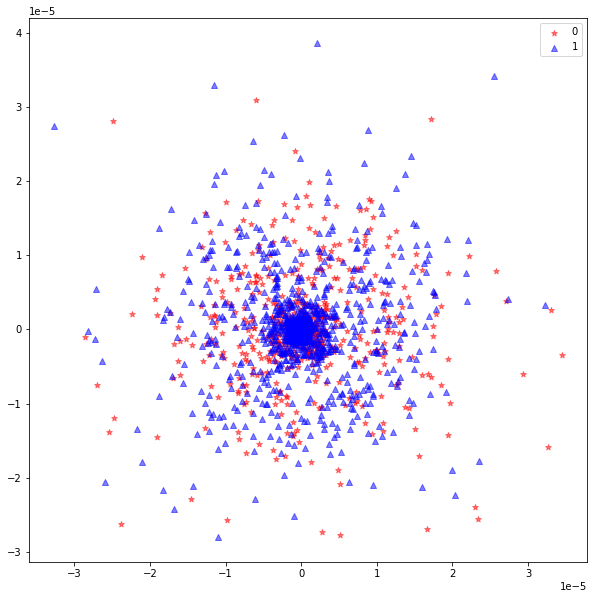

In [191]:
train_embs,train_labels = extract_embeddings(train_X_supercond_tensor , train_label_supercond, model)


# sample some of them for plotting
embs_resample_train, labels_resample_train = smaples_for_plotting(0.5, train_label_supercond, train_embs)

name = 'cosine'
train_dis = dissim_matrix(embs_resample_train, name)
embedded_2_train = mds.fit_transform(train_dis)
plot_embeddings(embedded_2_train, labels_resample_train)

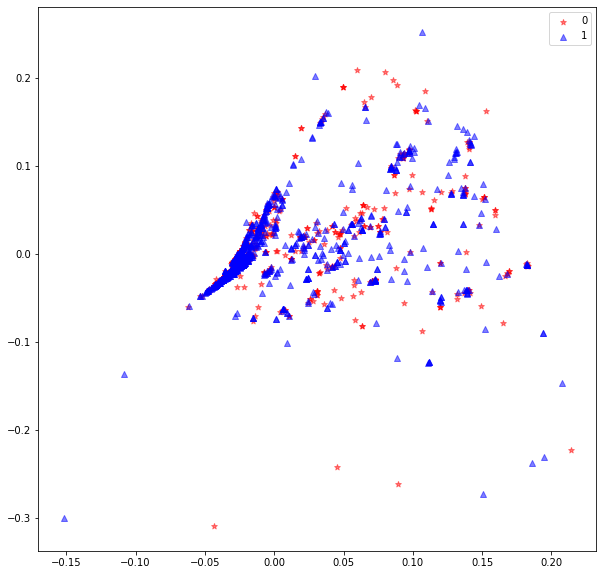

In [192]:

orig_data_train, labels_resample_orig_train = smaples_for_plotting(0.5, train_label_supercond,train_X_supercond_tensor)

name = 'cosine'
train_orig_dis = dissim_matrix(orig_data_train, name)

embedded_2_train_orig = mds.fit_transform(train_orig_dis)
plot_embeddings(embedded_2_train_orig, labels_resample_orig_train)

#### visual test

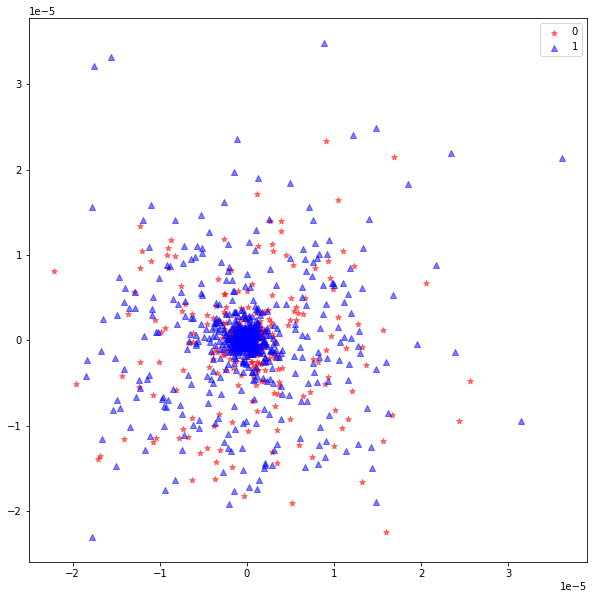

In [193]:
test_embs,test_labels = extract_embeddings(test_X_supercond_tensor , test_label_supercond, model)


# sample some of them for plotting
embs_resample_test, labels_resample_test = smaples_for_plotting(0.5, test_label_supercond, test_embs)

name = 'cosine'
test_dis = dissim_matrix(embs_resample_test, name)
embedded_2_test = mds.fit_transform(test_dis)
plot_embeddings(embedded_2_test, labels_resample_test)

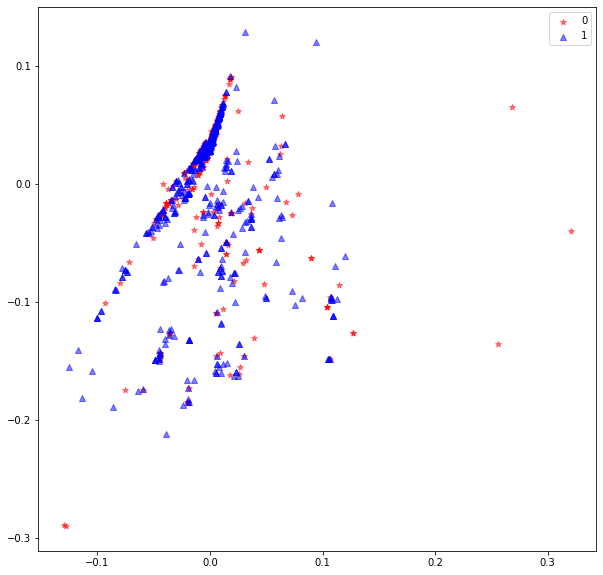

In [194]:
orig_data_test, labels_resample_orig_test = smaples_for_plotting(0.5, test_label_supercond,test_X_supercond_tensor)

name = 'cosine'
test_orig_dis = dissim_matrix(orig_data_test, name)

embedded_2_test_orig = mds.fit_transform(test_orig_dis)
plot_embeddings(embedded_2_test_orig , labels_resample_orig_test)

### Diffusion - gs mixture

In [163]:
diffusion = pd.read_csv('./data/Diffusion_data.csv')
diffusion_shuffled = diffusion.sample(frac=1).reset_index(drop=True)
drop_columns = ['E_regression', 'E_regression_shift', 'group',
               'Material compositions 2', 'Material compositions 1']
diffusion_shuffled  = diffusion_shuffled .drop(drop_columns, axis = 1)
labels = GaussianMixture(n_components=2, random_state=0).fit_predict(diffusion_shuffled)


In [164]:
train_X_diffu, test_X_diffu,train_label_diffu, test_label_diffu = train_test_split(
    diffusion_shuffled, labels, test_size=0.33, random_state=42)

train_X_diffu_tensor = torch.tensor(train_X_diffu.values )
test_X_diffu_tensor = torch.tensor(test_X_diffu.values )

In [169]:
distance = None
margin = 2

lam = 1
# method = 'sct'
method = 'hn' #shn now is the best
loss_fn = SCTLossCosine( method = method, lam = lam)

lr = 1e-4

hidden_size = 100
embedding_size = 20
input_size = train_X_diffu_tensor.shape[1]
net = EmbeddingNet(input_size, hidden_size, embedding_size)
siamese_net = SiameseNet(  embedding_net = net )



model = siamese_net
model = model.float() 
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 80

datasampler = BatchPairSampling( dataset = train_X_diffu_tensor, labels= train_label_diffu)
batch_size = 100
train_loader = torch.utils.data.DataLoader(datasampler, batch_size=batch_size, shuffle=True)

interval = 10

In [170]:
%%time
fit(train_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, interval)

Train: [0/273 (0%)]	Loss: 0.655756
Epoch: 1/80. Train set: Average loss: 0.6462
Train: [0/273 (0%)]	Loss: 0.613153
Epoch: 2/80. Train set: Average loss: 0.6101
Train: [0/273 (0%)]	Loss: 0.600639
Epoch: 3/80. Train set: Average loss: 0.5801
Train: [0/273 (0%)]	Loss: 0.544872
Epoch: 4/80. Train set: Average loss: 0.5398
Train: [0/273 (0%)]	Loss: 0.516456
Epoch: 5/80. Train set: Average loss: 0.4974
Train: [0/273 (0%)]	Loss: 0.495189
Epoch: 6/80. Train set: Average loss: 0.4691
Train: [0/273 (0%)]	Loss: 0.458115
Epoch: 7/80. Train set: Average loss: 0.4662
Train: [0/273 (0%)]	Loss: 0.464639
Epoch: 8/80. Train set: Average loss: 0.4335
Train: [0/273 (0%)]	Loss: 0.400644
Epoch: 9/80. Train set: Average loss: 0.4131
Train: [0/273 (0%)]	Loss: 0.409280
Epoch: 10/80. Train set: Average loss: 0.4071
Train: [0/273 (0%)]	Loss: 0.357666
Epoch: 11/80. Train set: Average loss: 0.3843
Train: [0/273 (0%)]	Loss: 0.406813
Epoch: 12/80. Train set: Average loss: 0.3715
Train: [0/273 (0%)]	Loss: 0.362100
Ep

#### Visualize train

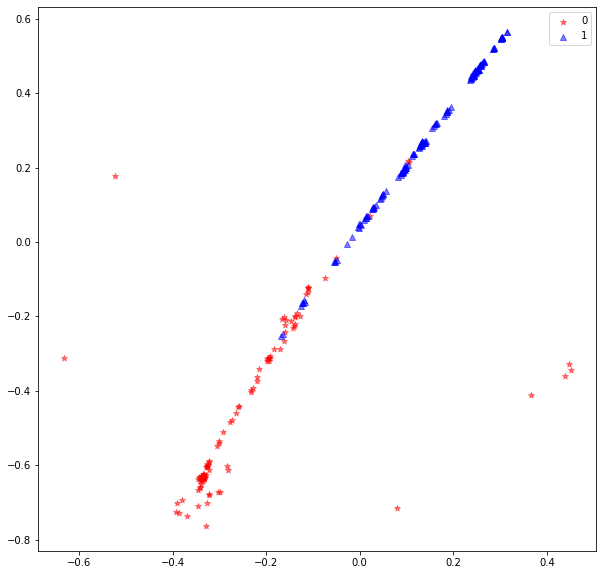

In [171]:
train_embs,train_labels = extract_embeddings(train_X_diffu_tensor , train_label_diffu, model)
name = 'cosine'
train_dis = dissim_matrix(train_embs, name)
embedded_2_train = mds.fit_transform(train_dis)
plot_embeddings(embedded_2_train, train_labels)

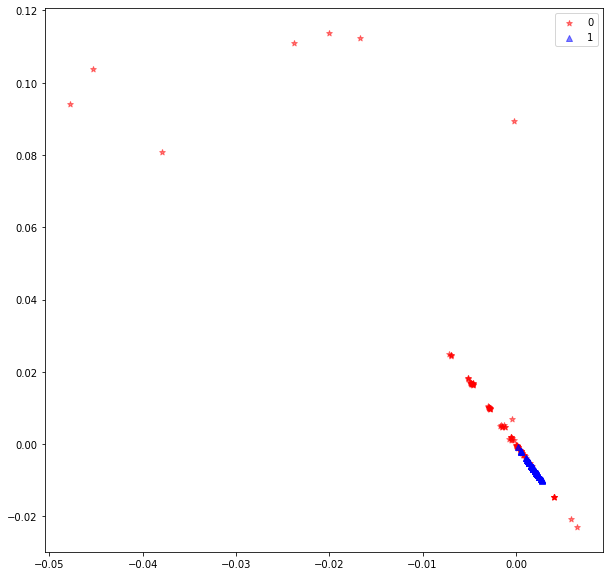

In [172]:
name = 'cosine'
train_orig_dis = dissim_matrix(train_X_diffu_tensor, name)

embedded_2_train_orig = mds.fit_transform(train_orig_dis)
plot_embeddings(embedded_2_train_orig, train_labels)

#### Visualize test

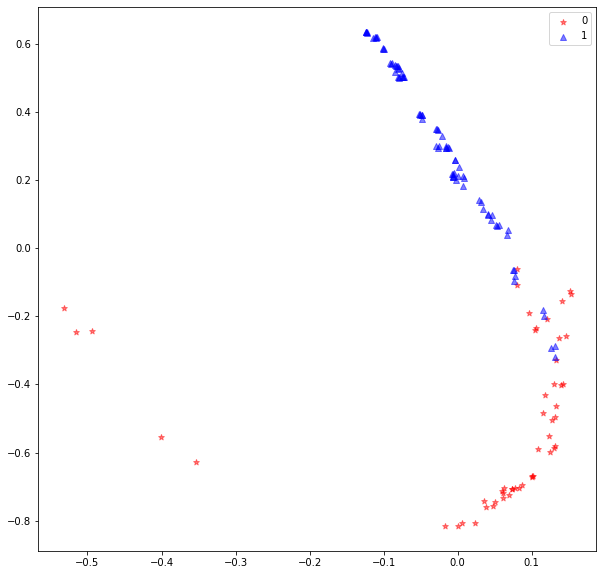

In [173]:
test_embs,test_labels = extract_embeddings(test_X_diffu_tensor , test_label_diffu, model)
name = 'cosine'
test_dis = dissim_matrix(test_embs, name)
embedded_2_test = mds.fit_transform(test_dis)
plot_embeddings(embedded_2_test, test_labels)

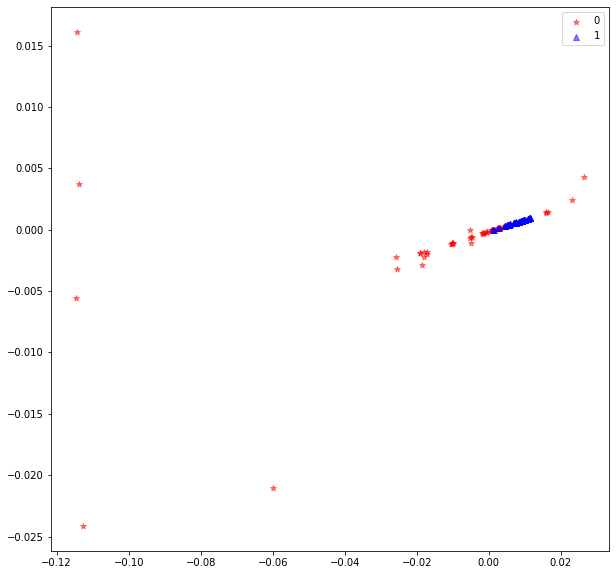

In [174]:
name = 'cosine'
test_orig_dis = dissim_matrix(test_X_diffu_tensor, name)

embedded_2_test_orig = mds.fit_transform(test_orig_dis)
plot_embeddings(embedded_2_test_orig, test_labels)

### Supercond - GS mixture

In [71]:
supercond = pd.read_excel('./data/Supercon_data_features_selected.xlsx')
supercond_shuffled = supercond.sample(frac=1).reset_index(drop=True)

drop_columns = [
                 'name',
                 'group',
                 'Tc', 'ln(Tc)'
                 ]
supercond_shuffled  = supercond_shuffled .drop(drop_columns, axis = 1)

labels = GaussianMixture(n_components=2, random_state=0).fit_predict(supercond_shuffled )

In [72]:
train_X_supercond, test_X_supercond,train_label_supercond, test_label_supercond = train_test_split(
    supercond_shuffled, labels, test_size=0.33, random_state=42)

train_X_supercond_tensor = torch.tensor(train_X_supercond.values )
test_X_supercond_tensor = torch.tensor(test_X_supercond.values )

In [73]:
distance = None
margin = 2

lam = 1
# method = 'sct'
method = 'hn' #shn now is the best
loss_fn = SCTLossCosine( method = method, lam = lam)
lr = 1e-4

hidden_size = 100
embedding_size = 20
input_size = train_X_supercond_tensor.shape[1]
net = EmbeddingNet(input_size, hidden_size, embedding_size)
siamese_net = SiameseNet(  embedding_net = net )



model = siamese_net
model = model.float() 
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 50

datasampler = BatchPairSampling( dataset = train_X_supercond_tensor, labels= train_label_supercond)
batch_size = 25
train_loader = torch.utils.data.DataLoader(datasampler, batch_size=batch_size, shuffle=True)

interval = 200

In [74]:
%%time
fit(train_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, interval)

Train: [0/4188 (0%)]	Loss: 0.672064
Epoch: 1/50. Train set: Average loss: 0.3577
Train: [0/4188 (0%)]	Loss: 0.320083
Epoch: 2/50. Train set: Average loss: 0.3134
Train: [0/4188 (0%)]	Loss: 0.221162
Epoch: 3/50. Train set: Average loss: 0.3076
Train: [0/4188 (0%)]	Loss: 0.190593
Epoch: 4/50. Train set: Average loss: 0.2792
Train: [0/4188 (0%)]	Loss: 0.150628
Epoch: 5/50. Train set: Average loss: 0.3078
Train: [0/4188 (0%)]	Loss: 0.331594
Epoch: 6/50. Train set: Average loss: 0.2833
Train: [0/4188 (0%)]	Loss: 0.499744
Epoch: 7/50. Train set: Average loss: 0.2905
Train: [0/4188 (0%)]	Loss: 0.219808
Epoch: 8/50. Train set: Average loss: 0.2866
Train: [0/4188 (0%)]	Loss: 0.165455
Epoch: 9/50. Train set: Average loss: 0.2513
Train: [0/4188 (0%)]	Loss: 0.210123
Epoch: 10/50. Train set: Average loss: 0.2429
Train: [0/4188 (0%)]	Loss: 0.234910
Epoch: 11/50. Train set: Average loss: 0.2475
Train: [0/4188 (0%)]	Loss: 0.289102
Epoch: 12/50. Train set: Average loss: 0.2385
Train: [0/4188 (0%)]	Loss

#### Visualize train

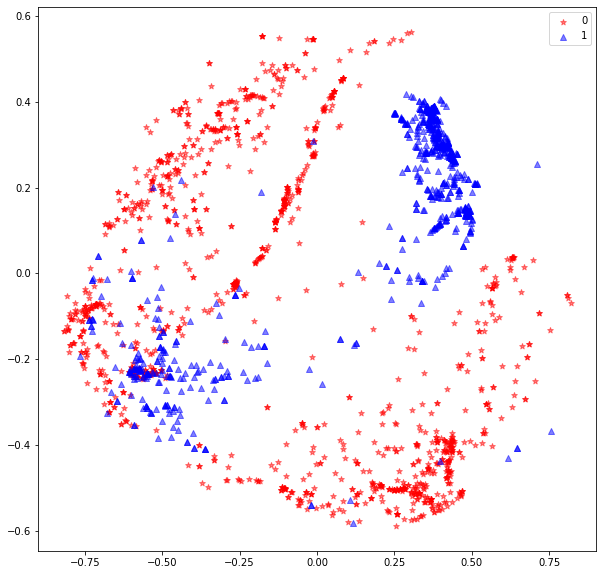

In [78]:
train_embs,train_labels = extract_embeddings(train_X_supercond_tensor , train_label_supercond, model)


# sample some of them for plotting
embs_resample_train, labels_resample_train = smaples_for_plotting(0.5, train_label_supercond, train_embs)

name = 'cosine'
train_dis = dissim_matrix(embs_resample_train, name)
embedded_2_train = mds.fit_transform(train_dis)
plot_embeddings(embedded_2_train, labels_resample_train)

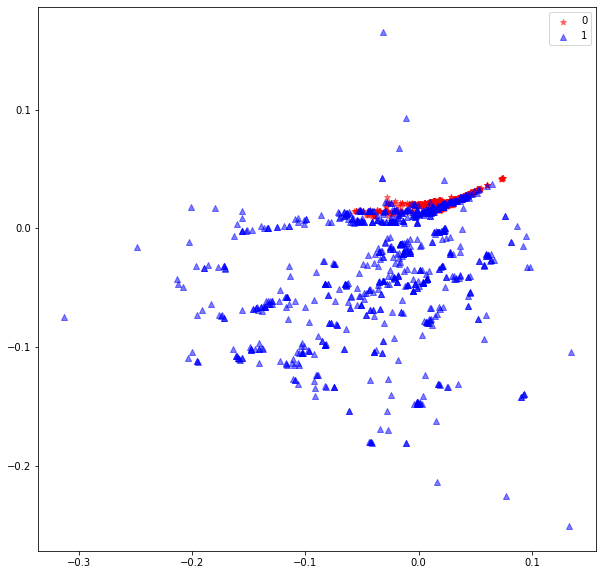

In [79]:
orig_data_train, labels_resample_orig_train = smaples_for_plotting(0.5, train_label_supercond,train_X_supercond_tensor)

name = 'cosine'
train_orig_dis = dissim_matrix(orig_data_train, name)

embedded_2_train_orig = mds.fit_transform(train_orig_dis)
plot_embeddings(embedded_2_train_orig, labels_resample_orig_train)

#### Visualize test

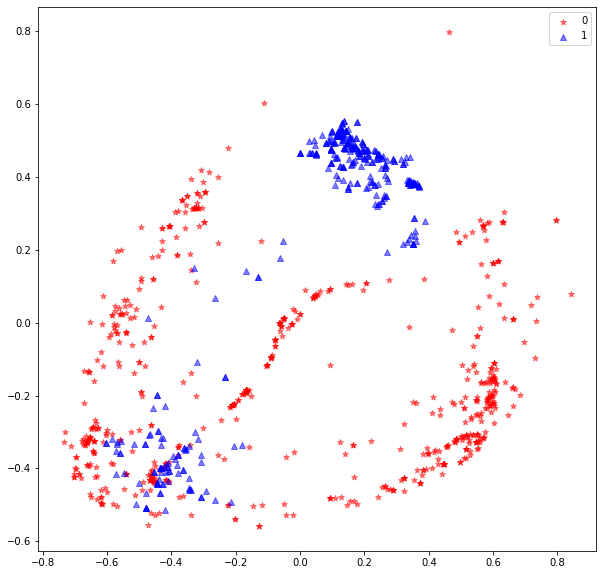

In [80]:
test_embs,test_labels = extract_embeddings(test_X_supercond_tensor , test_label_supercond, model)


# sample some of them for plotting
embs_resample_test, labels_resample_test = smaples_for_plotting(0.5, test_label_supercond, test_embs)

name = 'cosine'
test_dis = dissim_matrix(embs_resample_test, name)
embedded_2_test = mds.fit_transform(test_dis)
plot_embeddings(embedded_2_test, labels_resample_test)

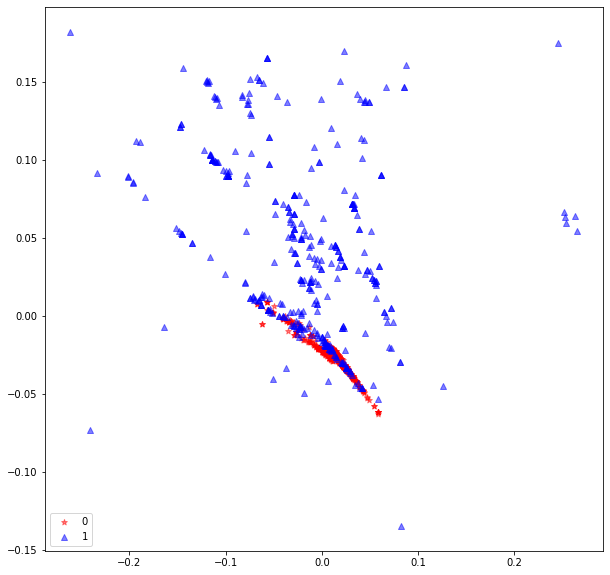

In [81]:
orig_data_test, labels_resample_orig_test = smaples_for_plotting(0.5, test_label_supercond,test_X_supercond_tensor)

name = 'cosine'
test_orig_dis = dissim_matrix(orig_data_test, name)

embedded_2_test_orig = mds.fit_transform(test_orig_dis)
plot_embeddings(embedded_2_test_orig , labels_resample_orig_test)